In [ ]:
# Imports
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive')

# save to local
!cp -r /content/drive/MyDrive/processed_splits /content/



Mounted at /content/drive/


In [2]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
import shutil
import numpy as np
import torchvision
import albumentations as A

from data_augmentation import augmentation
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from transformers import ViTForImageClassification, ViTFeatureExtractor
from PIL import Image, UnidentifiedImageError
import torchvision.datasets as datasets

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
model.to(device)

cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

## Data Preperation

In [ ]:
# Apply augmentation here
# remember to change input_folder and output_folder!!!
char_list = ['dori', 'lisa', 'amber', 'childe', 'venti', 'zhongli', 'eula', 'ganyu', 'hutao', 'yoimiya', 'raiden', 'nahida']
augmentation.process_folder(char_list, num_aug=3)

Processed 1.jpg_person_0.jpg
Processed 123.jpg_person_0.jpg
Processed 1234.jpg
Processed 1528299.jpg_person_0.jpg
Processed 1k1tus74c44c1.jpg_person_0.jpg
Processed 20240521_664c62af13e2b.jpg_person_0.jpg
Processed 20240521_664c62b0a10df.jpg_person_0.jpg
Processed 2d7e8fd5c08794cdb6efffb9d3e864f1_573116708228114109.jpg
Processed 470570.jpg
Processed 4d273b13111fd010b9d2ebc66d797027.jpg_person_0.jpg
Processed 4f743c664e576f0453a417a79fb223db_2156934232139002302.jpg_person_0.jpg
Processed 4l3uc8z96rz91.jpg_person_0.jpg
Processed 57002ey.jpg
Processed 5_f4b100cf-c9be-4efe-81e3-de6c9f1939b9.jpg_person_0.jpg
Processed 640x640q90.jpg
Processed 67087ef0efa502d7edb27ca561413c93.jpg_person_0.jpg
Processed 815818012ab7c5b5832be3ea2cbf994a_6081765440921617244.jpg_person_0.jpg
Processed 89c158a4ba8bc1638a057724a23c405a.jpg_person_0.jpg
Processed b05db2010dd6aa3bd72385a3bc176f54_1148165468859077393.jpg_person_0.jpg
Processed c29821593aeaf5490b122befc2f8a545_580631687357654309.jpg
Processed CGI209DR

In [ ]:
# Target is on all the root directory for all the _extracted folders
dataset_dir = '/dataset/augmented'
train_dir = '/content/processed_splits/train'  # Destination for training set
test_dir = '/content/processed_splits/test'    # Destination for test set
val_dir = '/content/processed_splits/val'    # Destination for validation set

In [ ]:
def train_test_val_split(dataset_dir, test_size, val_size):
    for character_folder in os.listdir(dataset_dir):
        character_path = os.path.join(dataset_dir, character_folder)

        if os.path.isdir(character_path):
            # Get all image filenames for the current character
            images = os.listdir(character_path)

            # Split into train+val and test sets
            train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=5242)

            # Split train_val into train and val sets
            train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=5242)

            # Create train, val, and test subfolders for the character
            train_character_dir = os.path.join(train_dir, character_folder)
            val_character_dir = os.path.join(val_dir, character_folder)
            test_character_dir = os.path.join(test_dir, character_folder)
            os.makedirs(train_character_dir, exist_ok=True)
            os.makedirs(val_character_dir, exist_ok=True)
            os.makedirs(test_character_dir, exist_ok=True)

            # Move training images
            for image in train_images:
                src_image_path = os.path.join(character_path, image)
                dst_image_path = os.path.join(train_character_dir, image)
                shutil.copy(src_image_path, dst_image_path)

            # Move validation images
            for image in val_images:
                src_image_path = os.path.join(character_path, image)
                dst_image_path = os.path.join(val_character_dir, image)
                shutil.copy(src_image_path, dst_image_path)

            # Move testing images
            for image in test_images:
                src_image_path = os.path.join(character_path, image)
                dst_image_path = os.path.join(test_character_dir, image)
                shutil.copy(src_image_path, dst_image_path)

            print(f'Successfully split {character_folder} into train/test/val sets.')

In [ ]:
# Define split ratios
test_size = 0.15
val_size = 0.15

In [ ]:
train_test_val_split(dataset_dir, test_size, val_size)

Successfully split amber_augmented into train/test/val sets.
Successfully split childe_augmented into train/test/val sets.
Successfully split dori_augmented into train/test/val sets.
Successfully split eula_augmented into train/test/val sets.
Successfully split ganyu_augmented into train/test/val sets.
Successfully split hutao_augmented into train/test/val sets.
Successfully split lisa_augmented into train/test/val sets.
Successfully split nahida_augmented into train/test/val sets.
Successfully split raiden_augmented into train/test/val sets.
Successfully split venti_augmented into train/test/val sets.
Successfully split yoimiya_augmented into train/test/val sets.
Successfully split zhongli_augmented into train/test/val sets.


In [ ]:
# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=transform)

# Pass these datasets to DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class SafeImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None):
        super(SafeImageFolder, self).__init__(root, transform)
        self.samples = self._filter_corrupted_samples(self.samples)

    def _filter_corrupted_samples(self, samples):
        valid_samples = []
        for path, label in samples:
            try:
                with Image.open(path) as img:
                    img.verify()
                valid_samples.append((path, label))
            except (IOError, UnidentifiedImageError):
                print(f"Skip bad image: {path}")
        return valid_samples

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = SafeImageFolder(root='/content/processed_splits/train/', transform=transform)
val_dataset = SafeImageFolder(root='/content/processed_splits/val/', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)


损坏的图像文件已跳过: /content/processed_splits/train/amber_augmented/google_0149.jpg_person_0_aug_2.jpg


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Training

In [ ]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False, maximize=False, foreach=None, capturable=False, differentiable=False, fused=None)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


## Evaluation

使用设备: cuda


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


损坏的图像文件已跳过: /content/processed_splits/train/amber_augmented/google_0149.jpg_person_0_aug_2.jpg


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



=== Training with ReLU activation ===



<ipython-input-5-8d37a7a23e68>:57: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Epoch 1/30
----------


Training:   0%|          | 0/183 [00:00<?, ?it/s]<ipython-input-5-8d37a7a23e68>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Training Loss: 0.6724 Acc: 0.8097


Validation:   0%|          | 0/42 [00:00<?, ?it/s]<ipython-input-5-8d37a7a23e68>:111: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Validation Loss: 0.1979 Acc: 0.9519
Best model saved.
Epoch 2/30
----------


Training Loss: 0.1500 Acc: 0.9595


Validation Loss: 0.1187 Acc: 0.9722
Best model saved.
Epoch 3/30
----------


Training Loss: 0.0670 Acc: 0.9850


Validation Loss: 0.1218 Acc: 0.9586
No improvement for 1 epoch(s).
Epoch 4/30
----------


Training Loss: 0.0419 Acc: 0.9913


Validation Loss: 0.0827 Acc: 0.9737
Best model saved.
Epoch 5/30
----------


Training Loss: 0.0233 Acc: 0.9966


Validation Loss: 0.0886 Acc: 0.9699
No improvement for 1 epoch(s).
Epoch 6/30
----------


Training Loss: 0.0188 Acc: 0.9966


Validation Loss: 0.0789 Acc: 0.9752
Best model saved.
Epoch 7/30
----------


Training Loss: 0.0131 Acc: 0.9983


Validation Loss: 0.1015 Acc: 0.9662
No improvement for 1 epoch(s).
Epoch 8/30
----------


Training Loss: 0.0119 Acc: 0.9985


Validation Loss: 0.1010 Acc: 0.9669
No improvement for 2 epoch(s).
Epoch 9/30
----------


Training Loss: 0.0134 Acc: 0.9966


Validation Loss: 0.0937 Acc: 0.9707
No improvement for 3 epoch(s).
Epoch 10/30
----------


Training Loss: 0.0093 Acc: 0.9985


Validation Loss: 0.0870 Acc: 0.9752
No improvement for 4 epoch(s).
Epoch 11/30
----------


Training Loss: 0.0056 Acc: 0.9993


Validation Loss: 0.0766 Acc: 0.9759
Best model saved.
Epoch 12/30
----------


Training Loss: 0.0048 Acc: 0.9993


Validation Loss: 0.0781 Acc: 0.9744
No improvement for 1 epoch(s).
Epoch 13/30
----------


Training Loss: 0.0034 Acc: 1.0000


Validation Loss: 0.0778 Acc: 0.9759
No improvement for 2 epoch(s).
Epoch 14/30
----------


Training Loss: 0.0028 Acc: 1.0000


Validation Loss: 0.0775 Acc: 0.9759
No improvement for 3 epoch(s).
Epoch 15/30
----------


Training Loss: 0.0025 Acc: 0.9998


Validation Loss: 0.0769 Acc: 0.9767
Best model saved.
Epoch 16/30
----------


Training Loss: 0.0021 Acc: 1.0000


Validation Loss: 0.0753 Acc: 0.9774
Best model saved.
Epoch 17/30
----------


Training Loss: 0.0024 Acc: 0.9998


Validation Loss: 0.0758 Acc: 0.9774
No improvement for 1 epoch(s).
Epoch 18/30
----------


Training Loss: 0.0019 Acc: 1.0000


Validation Loss: 0.0740 Acc: 0.9782
Best model saved.
Epoch 19/30
----------


Training Loss: 0.0021 Acc: 1.0000


Validation Loss: 0.0735 Acc: 0.9789
Best model saved.
Epoch 20/30
----------


Training Loss: 0.0022 Acc: 1.0000


Validation Loss: 0.0742 Acc: 0.9789
No improvement for 1 epoch(s).
Epoch 21/30
----------


Training Loss: 0.0015 Acc: 1.0000


Validation Loss: 0.0739 Acc: 0.9789
No improvement for 2 epoch(s).
Epoch 22/30
----------


Training Loss: 0.0019 Acc: 1.0000


Validation Loss: 0.0737 Acc: 0.9789
No improvement for 3 epoch(s).
Epoch 23/30
----------


Training Loss: 0.0019 Acc: 1.0000


Validation Loss: 0.0737 Acc: 0.9789
No improvement for 4 epoch(s).
Epoch 24/30
----------


Training Loss: 0.0017 Acc: 1.0000


Validation Loss: 0.0734 Acc: 0.9789
No improvement for 5 epoch(s).
Early stopping triggered.
[ReLU] Training complete. Best Validation Accuracy: 0.9789

=== Training with LeakyReLU activation ===

Epoch 1/30
----------


Training Loss: 0.6238 Acc: 0.8161


Validation Loss: 0.1917 Acc: 0.9474
Best model saved.
Epoch 2/30
----------


Training Loss: 0.1399 Acc: 0.9624


Validation Loss: 0.1165 Acc: 0.9677
Best model saved.
Epoch 3/30
----------


Training Loss: 0.0669 Acc: 0.9845


Validation Loss: 0.1168 Acc: 0.9617
No improvement for 1 epoch(s).
Epoch 4/30
----------


Training Loss: 0.0403 Acc: 0.9903


Validation Loss: 0.0968 Acc: 0.9714
Best model saved.
Epoch 5/30
----------


Training Loss: 0.0301 Acc: 0.9935


Validation Loss: 0.0915 Acc: 0.9707
No improvement for 1 epoch(s).
Epoch 6/30
----------


Training Loss: 0.0175 Acc: 0.9971


Validation Loss: 0.0798 Acc: 0.9759
Best model saved.
Epoch 7/30
----------


Training Loss: 0.0111 Acc: 0.9988


Validation Loss: 0.0864 Acc: 0.9714
No improvement for 1 epoch(s).
Epoch 8/30
----------


Training Loss: 0.0093 Acc: 0.9988


Validation Loss: 0.0918 Acc: 0.9714
No improvement for 2 epoch(s).
Epoch 9/30
----------


Training Loss: 0.0088 Acc: 0.9988


Validation Loss: 0.0869 Acc: 0.9774
Best model saved.
Epoch 10/30
----------


Training Loss: 0.0145 Acc: 0.9962


Validation Loss: 0.1286 Acc: 0.9647
No improvement for 1 epoch(s).
Epoch 11/30
----------


Training Loss: 0.0096 Acc: 0.9971


Validation Loss: 0.0860 Acc: 0.9744
No improvement for 2 epoch(s).
Epoch 12/30
----------


Training Loss: 0.0043 Acc: 0.9998


Validation Loss: 0.0843 Acc: 0.9744
No improvement for 3 epoch(s).
Epoch 13/30
----------


Training Loss: 0.0039 Acc: 0.9998


Validation Loss: 0.0833 Acc: 0.9744
No improvement for 4 epoch(s).
Epoch 14/30
----------


Training Loss: 0.0038 Acc: 0.9998


Validation Loss: 0.0810 Acc: 0.9759
No improvement for 5 epoch(s).
Early stopping triggered.
[LeakyReLU] Training complete. Best Validation Accuracy: 0.9774

=== Training with ELU activation ===

Epoch 1/30
----------


Training Loss: 0.5345 Acc: 0.8483


Validation Loss: 0.1670 Acc: 0.9549
Best model saved.
Epoch 2/30
----------


Training Loss: 0.1150 Acc: 0.9699


Validation Loss: 0.1308 Acc: 0.9594
Best model saved.
Epoch 3/30
----------


Training Loss: 0.0507 Acc: 0.9880


Validation Loss: 0.1086 Acc: 0.9647
Best model saved.
Epoch 4/30
----------


Training Loss: 0.0279 Acc: 0.9949


Validation Loss: 0.0944 Acc: 0.9692
Best model saved.
Epoch 5/30
----------


Training Loss: 0.0152 Acc: 0.9981


Validation Loss: 0.0844 Acc: 0.9714
Best model saved.
Epoch 6/30
----------


Training Loss: 0.0111 Acc: 0.9986


Validation Loss: 0.0847 Acc: 0.9737
Best model saved.
Epoch 7/30
----------


Training Loss: 0.0076 Acc: 0.9993


Validation Loss: 0.0874 Acc: 0.9729
No improvement for 1 epoch(s).
Epoch 8/30
----------


Training Loss: 0.0044 Acc: 0.9998


Validation Loss: 0.0900 Acc: 0.9737
No improvement for 2 epoch(s).
Epoch 9/30
----------


Training Loss: 0.0034 Acc: 0.9998


Validation Loss: 0.0887 Acc: 0.9714
No improvement for 3 epoch(s).
Epoch 10/30
----------


Training Loss: 0.0050 Acc: 0.9995


Validation Loss: 0.0878 Acc: 0.9707
No improvement for 4 epoch(s).
Epoch 11/30
----------


Training Loss: 0.0031 Acc: 0.9993


Validation Loss: 0.0830 Acc: 0.9714
No improvement for 5 epoch(s).
Early stopping triggered.
[ELU] Training complete. Best Validation Accuracy: 0.9737

=== Training with Sigmoid activation ===

Epoch 1/30
----------


Training Loss: 1.1053 Acc: 0.7585


Validation Loss: 0.4015 Acc: 0.9406
Best model saved.
Epoch 2/30
----------


Training Loss: 0.2862 Acc: 0.9481


Validation Loss: 0.1956 Acc: 0.9609
Best model saved.
Epoch 3/30
----------


Training Loss: 0.1491 Acc: 0.9768


Validation Loss: 0.1420 Acc: 0.9669
Best model saved.
Epoch 4/30
----------


Training Loss: 0.0883 Acc: 0.9868


Validation Loss: 0.1166 Acc: 0.9692
Best model saved.
Epoch 5/30
----------


Training Loss: 0.0579 Acc: 0.9942


Validation Loss: 0.0986 Acc: 0.9767
Best model saved.
Epoch 6/30
----------


Training Loss: 0.0405 Acc: 0.9962


Validation Loss: 0.0940 Acc: 0.9737
No improvement for 1 epoch(s).
Epoch 7/30
----------


Training Loss: 0.0297 Acc: 0.9978


Validation Loss: 0.0880 Acc: 0.9759
No improvement for 2 epoch(s).
Epoch 8/30
----------


Training Loss: 0.0221 Acc: 0.9986


Validation Loss: 0.0827 Acc: 0.9767
No improvement for 3 epoch(s).
Epoch 9/30
----------


Training Loss: 0.0170 Acc: 0.9998


Validation Loss: 0.0840 Acc: 0.9752
No improvement for 4 epoch(s).
Epoch 10/30
----------


Training Loss: 0.0139 Acc: 0.9995


Validation Loss: 0.0755 Acc: 0.9797
Best model saved.
Epoch 11/30
----------


Training Loss: 0.0108 Acc: 0.9998


Validation Loss: 0.0757 Acc: 0.9782
No improvement for 1 epoch(s).
Epoch 12/30
----------


Training Loss: 0.0096 Acc: 1.0000


Validation Loss: 0.0757 Acc: 0.9774
No improvement for 2 epoch(s).
Epoch 13/30
----------


Training Loss: 0.0097 Acc: 0.9998


Validation Loss: 0.0754 Acc: 0.9767
No improvement for 3 epoch(s).
Epoch 14/30
----------


Training Loss: 0.0090 Acc: 1.0000


Validation Loss: 0.0755 Acc: 0.9782
No improvement for 4 epoch(s).
Epoch 15/30
----------


Training Loss: 0.0087 Acc: 0.9997


Validation Loss: 0.0757 Acc: 0.9782
No improvement for 5 epoch(s).
Early stopping triggered.
[Sigmoid] Training complete. Best Validation Accuracy: 0.9797

=== Training with Tanh activation ===

Epoch 1/30
----------


Training Loss: 0.5701 Acc: 0.8564


Validation Loss: 0.1782 Acc: 0.9617
Best model saved.
Epoch 2/30
----------


Training Loss: 0.1083 Acc: 0.9775


Validation Loss: 0.1233 Acc: 0.9699
Best model saved.
Epoch 3/30
----------


Training Loss: 0.0473 Acc: 0.9932


Validation Loss: 0.1101 Acc: 0.9662
No improvement for 1 epoch(s).
Epoch 4/30
----------


Training Loss: 0.0212 Acc: 0.9985


Validation Loss: 0.0939 Acc: 0.9699
No improvement for 2 epoch(s).
Epoch 5/30
----------


Training Loss: 0.0121 Acc: 0.9993


Validation Loss: 0.0859 Acc: 0.9729
Best model saved.
Epoch 6/30
----------


Training Loss: 0.0088 Acc: 0.9993


Validation Loss: 0.0858 Acc: 0.9737
Best model saved.
Epoch 7/30
----------


Training Loss: 0.0051 Acc: 1.0000


Validation Loss: 0.0798 Acc: 0.9752
Best model saved.
Epoch 8/30
----------


Training Loss: 0.0039 Acc: 1.0000


Validation Loss: 0.0803 Acc: 0.9744
No improvement for 1 epoch(s).
Epoch 9/30
----------


Training Loss: 0.0025 Acc: 1.0000


Validation Loss: 0.0797 Acc: 0.9752
No improvement for 2 epoch(s).
Epoch 10/30
----------


Training Loss: 0.0021 Acc: 1.0000


Validation Loss: 0.0775 Acc: 0.9774
Best model saved.
Epoch 11/30
----------


Training Loss: 0.0015 Acc: 1.0000


Validation Loss: 0.0770 Acc: 0.9767
No improvement for 1 epoch(s).
Epoch 12/30
----------


Training Loss: 0.0015 Acc: 1.0000


Validation Loss: 0.0771 Acc: 0.9774
No improvement for 2 epoch(s).
Epoch 13/30
----------


Training Loss: 0.0014 Acc: 1.0000


Validation Loss: 0.0774 Acc: 0.9774
No improvement for 3 epoch(s).
Epoch 14/30
----------


Training Loss: 0.0013 Acc: 1.0000


Validation Loss: 0.0774 Acc: 0.9767
No improvement for 4 epoch(s).
Epoch 15/30
----------


Training Loss: 0.0013 Acc: 1.0000


Validation Loss: 0.0775 Acc: 0.9767
No improvement for 5 epoch(s).
Early stopping triggered.
[Tanh] Training complete. Best Validation Accuracy: 0.9774


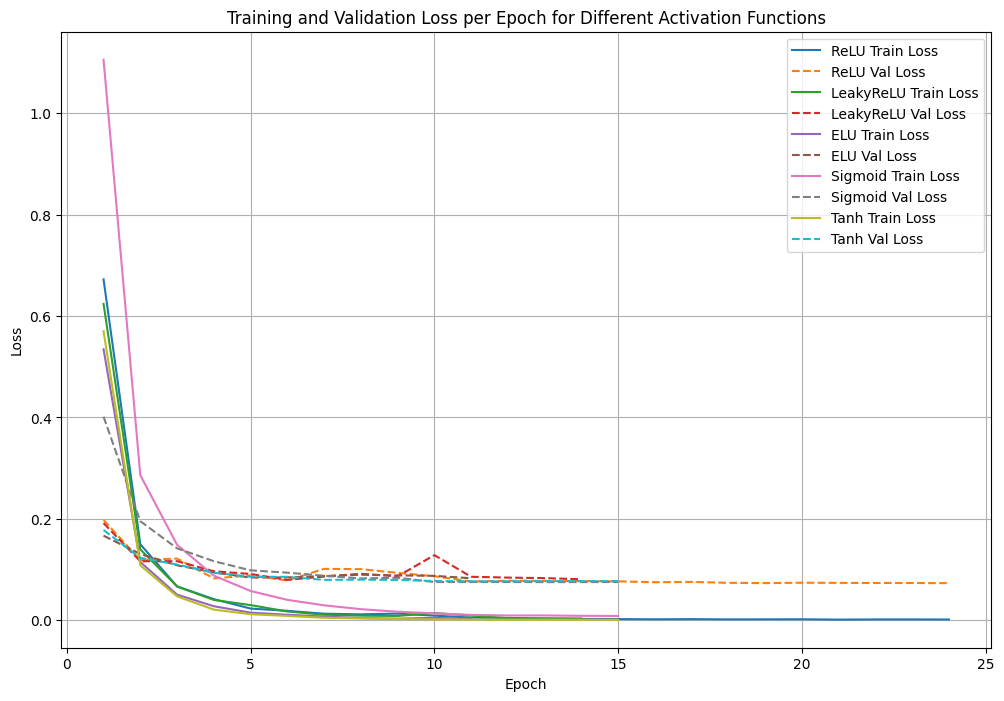

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
num_classes = 12
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, name, num_epochs=30, patience=5):
    best_val_accuracy = 0.0
    trigger_times = 0
    scaler = torch.cuda.amp.GradScaler()
    activation_name = name

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        for inputs, labels in tqdm(train_loader, desc='Training', leave=False):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs).logits
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = running_corrects.double() / total_samples

        train_losses.append(epoch_loss)

        print(f'Training Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation', leave=False):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                with torch.cuda.amp.autocast():
                    outputs = model(inputs).logits
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                val_total_samples += inputs.size(0)

        if val_total_samples == 0:
            print('No valid samples in validation set for this epoch.')
            val_accuracy = 0.0
            val_loss = 0.0
        else:
            val_accuracy = val_running_corrects.double() / val_total_samples
            val_loss = val_running_loss / val_total_samples

        val_losses.append(val_loss)

        print(f'Validation Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}')

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), f'best_model_{activation_name}.pth')
            print('Best model saved.')
            trigger_times = 0
        else:
            trigger_times += 1
            print(f'No improvement for {trigger_times} epoch(s).')

            if trigger_times >= patience:
                print('Early stopping triggered.')
                break

        scheduler.step()

    print(f'[{activation_name}] Training complete. Best Validation Accuracy: {best_val_accuracy:.4f}')
    return best_val_accuracy.item(), train_losses, val_losses

activation_functions = {
    'ReLU': nn.ReLU(),
    'LeakyReLU': nn.LeakyReLU(),
    'ELU': nn.ELU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

validation_accuracies = {}
training_losses = {}
validation_losses = {}

for name, activation in activation_functions.items():
    print(f'\n=== Training with {name} activation ===\n')

    model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    model.classifier = nn.Sequential(
        nn.Linear(model.config.hidden_size, 256),
        activation,
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )

    for param in model.vit.parameters():
        param.requires_grad = False

    model.to(device)
    optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    val_acc, train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, name, num_epochs=30, patience=5)
    validation_accuracies[name] = val_acc
    training_losses[name] = train_loss
    validation_losses[name] = val_loss

with open('validation_accuracies.json', 'w') as f:
    json.dump(validation_accuracies, f, indent=4)

plt.figure(figsize=(12, 8))

for name in activation_functions.keys():
    epochs = range(1, len(training_losses[name]) + 1)
    plt.plot(epochs, training_losses[name], label=f'{name} Train Loss')
    plt.plot(epochs, validation_losses[name], linestyle='--', label=f'{name} Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch for Different Activation Functions')
plt.legend()
plt.grid(True)
plt.savefig('loss_comparison.png')
plt.show()


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

32